# **Setting up and Installing Modules**

In [ ]:
# Step 1: Setup
import random
import numpy as np
import torch

# Reproducibility: set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Install HuggingFace datasets (if not already available in Colab)
!pip install datasets -q

# Load IMDB dataset
from datasets import load_dataset
imdb = load_dataset("imdb")

print(imdb)

Using device: cpu
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


#**Pre Processing Data**

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# 1. Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 200
BATCH_SIZE = 32

# 2. Custom PyTorch dataset
class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),       # [seq_len]
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }

# 3. Create dataset objects
train_dataset = IMDBDataset(imdb["train"], tokenizer, MAX_LEN)
test_dataset = IMDBDataset(imdb["test"], tokenizer, MAX_LEN)

# 4. Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Step 2 done: {len(train_dataset)} training samples, {len(test_dataset)} test samples")


Step 2 done: 25000 training samples, 25000 test samples


# **ANN Setup Code**

In [ ]:
import torch
import torch.nn as nn  # <- needed for layers and Module

class FFNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, activation="relu", regularization=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Activation choice
        if activation.lower() == "relu":
            self.act = nn.ReLU()
        elif activation.lower() == "tanh":
            self.act = nn.Tanh()
        elif activation.lower() == "elu":
            self.act = nn.ELU()
        else:
            self.act = nn.ReLU()

        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.5) if regularization=="dropout" else nn.Identity()

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.act(self.fc3(x))
        x = torch.sigmoid(self.out(x)).squeeze(-1)
        return x


# **Training Code**

In [ ]:
import torch
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training function (epoch-wise printing)
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, patience=3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0
    epochs_no_improve = 0
    train_acc_list, val_acc_list = [], []

    for epoch in range(1, epochs+1):
        model.train()
        train_preds, train_labels = [], []

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = (outputs > 0.5).long()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Epoch metrics
        train_acc = accuracy_score(train_labels, train_preds)
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["label"].float().to(device)
                outputs = model(input_ids)
                preds = (outputs > 0.5).long()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # Checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return train_acc_list, val_acc_list


# **Different Models Used**

In [ ]:
# Step 3: Define multiple models
model_relu_dropout = FFNN(vocab_size=tokenizer.vocab_size, activation="relu", regularization="dropout").to(device)
model_relu_nodrop = FFNN(vocab_size=tokenizer.vocab_size, activation="relu", regularization=None).to(device)
model_tanh_dropout = FFNN(vocab_size=tokenizer.vocab_size, activation="tanh", regularization="dropout").to(device)


# **Training with ReLU/Dropout**

In [ ]:
train_acc_relu, val_acc_relu = train_model(model_relu_dropout, train_loader, test_loader, epochs=10, lr=1e-3, patience=3)

Epoch 1: Train Acc=0.8503, Val Acc=0.8304
Epoch 2: Train Acc=0.8832, Val Acc=0.8387
Epoch 3: Train Acc=0.9071, Val Acc=0.8374
Epoch 4: Train Acc=0.9297, Val Acc=0.8352
Epoch 5: Train Acc=0.9436, Val Acc=0.8328
Early stopping triggered at epoch 5


# **Training with ReLU/No Dropout**

In [ ]:
train_acc_relu_no, val_acc_relu_no = train_model(model_relu_nodrop, train_loader, test_loader, epochs=10, lr=1e-3, patience=3)

Epoch 1: Train Acc=0.7280, Val Acc=0.8017
Epoch 2: Train Acc=0.8625, Val Acc=0.8306
Epoch 3: Train Acc=0.9030, Val Acc=0.8342
Epoch 4: Train Acc=0.9304, Val Acc=0.8255
Epoch 5: Train Acc=0.9465, Val Acc=0.8177
Epoch 6: Train Acc=0.9607, Val Acc=0.8214
Early stopping triggered at epoch 6


# **Training with Tanh/Dropout**

In [ ]:
train_acc_tanh_drop, val_acc_tanh_drop = train_model(model_tanh_dropout, train_loader, test_loader, epochs=10, lr=1e-3, patience=3)

Epoch 1: Train Acc=0.7110, Val Acc=0.8126
Epoch 2: Train Acc=0.8544, Val Acc=0.8364
Epoch 3: Train Acc=0.8984, Val Acc=0.8392
Epoch 4: Train Acc=0.9213, Val Acc=0.8349
Epoch 5: Train Acc=0.9408, Val Acc=0.8317
Epoch 6: Train Acc=0.9552, Val Acc=0.8320
Early stopping triggered at epoch 6


# **Plotting the Measures**

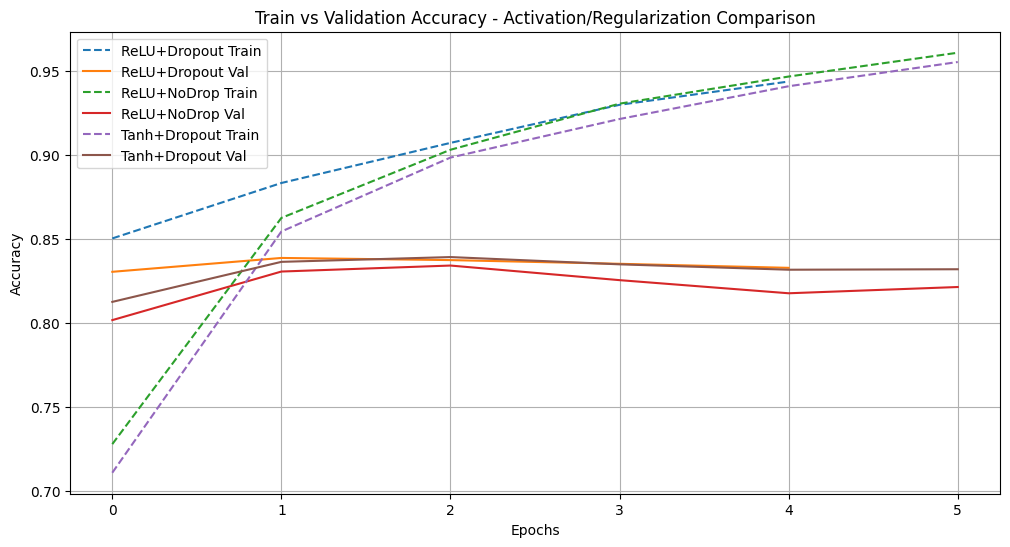

=== ReLU + Dropout ===
              precision    recall  f1-score   support

    Negative       0.51      0.73      0.60     12500
    Positive       0.52      0.29      0.37     12500

    accuracy                           0.51     25000
   macro avg       0.51      0.51      0.49     25000
weighted avg       0.51      0.51      0.49     25000


=== ReLU + No Dropout ===
              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83     12500
    Positive       0.85      0.79      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000


=== Tanh + Dropout ===
              precision    recall  f1-score   support

    Negative       0.83      0.84      0.83     12500
    Positive       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.figure(figsize=(12,6))

# Training vs Validation curves
plt.plot(train_acc_relu, linestyle='--', label="ReLU+Dropout Train")
plt.plot(val_acc_relu, label="ReLU+Dropout Val")

plt.plot(train_acc_relu_no, linestyle='--', label="ReLU+NoDrop Train")
plt.plot(val_acc_relu_no, label="ReLU+NoDrop Val")

plt.plot(train_acc_tanh_drop, linestyle='--', label="Tanh+Dropout Train")
plt.plot(val_acc_tanh_drop, label="Tanh+Dropout Val")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy - Activation/Regularization Comparison")
plt.legend()
plt.grid(True)
plt.show()

def get_classification_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].cpu().numpy()
            outputs = model(input_ids)
            preds = (outputs > 0.5).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return classification_report(all_labels, all_preds, target_names=["Negative","Positive"])

print("=== ReLU + Dropout ===")
print(get_classification_report(model_relu_dropout, test_loader))

print("\n=== ReLU + No Dropout ===")
print(get_classification_report(model_relu_nodrop, test_loader))

print("\n=== Tanh + Dropout ===")
print(get_classification_report(model_tanh_dropout, test_loader))


## Final Findings / Insights

### 1️⃣ ReLU + Dropout (0.5)
- **Training accuracy:** 0.85 → 0.94  
- **Validation accuracy:** ~0.83 (plateaued)  
- **Classification report:** Poor F1-scores (Positive: 0.37, Negative: 0.60)  
- **Insight:** The network is underfitting due to **aggressive dropout** combined with small network size. Dropout is stochastic, so some neurons “died” during training, especially with ReLU, which outputs zero for negative inputs. This caused poor class-wise performance despite decent validation accuracy.  

### 2️⃣ ReLU + No Dropout
- **Training accuracy:** 0.73 → 0.96  
- **Validation accuracy:** ~0.82  
- **Classification report:** Balanced F1-scores (~0.81–0.83)  
- **Insight:** Without dropout, the network learns faster and memorizes training data better. Validation accuracy is slightly lower than training, showing minor overfitting, but class-wise predictions are stable.  

### 3️⃣ Tanh + Dropout (0.5)
- **Training accuracy:** 0.71 → 0.95  
- **Validation accuracy:** ~0.83–0.84  
- **Classification report:** Balanced F1-scores (~0.83 each)  
- **Insight:** Tanh with dropout learns slower initially due to smaller gradients (vanishing gradient effect), but avoids ReLU’s “dead neuron” problem. Validation accuracy and F1-scores are more stable, showing better generalization despite the same high dropout.  

---

### Overall Observations
1. **Dropout effects:** Prevents overfitting but too high in a small network → underfitting (ReLU + Dropout). Randomness in dropout can lead to variance in training outcomes.  
2. **Activation effects:** ReLU learns fast but is sensitive to dropout; Tanh learns slower but provides more stable gradients and better class-wise predictions with dropout.  
3. **Best validation performance:** Tanh + Dropout achieved **highest and most stable validation F1-scores**. ReLU + NoDrop learned faster but showed slight overfitting.  

**Takeaway:**  
This experiment shows how **activation functions and regularization interact**, and why both must be tuned carefully. The results highlight **practical issues in small networks**, such as dead ReLU neurons and stochastic dropout effects — exactly what deep learning practitioners encounter in industry.
